Импорт необходимых зависимостей

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras import models, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from pathlib import Path
from tqdm.notebook import tqdm

Описание необходимых констант

In [2]:
FOLDER = 'D:\\Learning\\MSU\\th\\diploma_files'

### Класс Dataset

Предназначен для работы с наборами данных, хранящимися на диске, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [3]:
class Dataset:

    def __init__(self, path: str):
        self.is_loaded = False
        p = Path(FOLDER) / Path(path)
        if p.exists():
            # print(f'Loading dataset from {path}')
            np_obj = np.load(str(p))
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.gt_vectors = np_obj['gt_vectors']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            # print(f'Done. Dataset consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def batches_seq(self, batch_size=32):
        num = self.n_files // batch_size
        for i in range(num):
            yield self.images[i*batch_size: (i+1) * batch_size, :, :, :]
        if self.n_files % batch_size:
            yield self.images[num*batch_size:, :, :, :]

    def random_image_with_label_and_gt_vector(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i], self.gt_vectors[i]

    def random_batch_with_gt_vectors(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.gt_vectors[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность

In [4]:
class Metrics:

    @staticmethod
    def accuracy(gt, pred):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

### Класс Model

Класс, хранящий в себе всю информацию о модели.

In [5]:
class MySimpleClassifier:

    def __init__(self, input_shape, n_output_channels, n_filters):
        self.model = models.Sequential()
        self.model.add(Input(shape=input_shape))
        self.model.add(Conv2D(n_filters, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(n_filters, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(n_filters * 2, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(n_filters * 2, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size=(2, 2)))

        self.model.add(Conv2D(n_filters * 4, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(n_filters * 4, 3, activation='relu', padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(GlobalAveragePooling2D())

        self.model.add(Flatten())
        self.model.add(Dense(n_output_channels, activation='softmax'))

    def save(self, name: str):
        p = Path(name) / Path('my_checkpoint')
        self.model.save_weights(str(p))

    def load(self, name: str):
        p = Path(name) / Path('my_checkpoint')
        self.model.load_weights(str(p))

    def train(self, dataset: Dataset, val_images, val_gt_vectors):
        print(f'training started')
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
        self.model.fit(dataset.images,
                       dataset.gt_vectors,
                       epochs=7,
                       validation_data=(val_images, val_gt_vectors))
        print(f'training done')

    def test_on_dataset(self, dataset: Dataset):
        predictions = []
        for batch in dataset.batches_seq():
            predictions.extend(self.test_on_batch(batch))
        return predictions

    def test_on_batch(self, batch: np.ndarray):
        prediction = np.argmax(self.model.predict(batch), axis=1)
        return prediction


In [6]:
d_train = Dataset('npz_train/5.0.npz')
val_images, val_gt_vectors = d_train.random_batch_with_gt_vectors(int(d_train.n_files * 0.2))

In [6]:
model = MySimpleClassifier((224, 224, 3), 20, 4)

In [7]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 4)       112       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 4)       16        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 4)       148       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 4)       16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 8)       296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 8)       3

In [17]:
model.train(d_train, val_images, val_gt_vectors)
model.save('saved_models/model_trained_on_scale_5.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/10
4000/4000 [==============================] - 28s 7ms/sample - loss: 1.1575 - accuracy: 0.7195 - val_loss: 1.8028 - val_accuracy: 0.2537
Epoch 2/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.2632 - accuracy: 0.9735 - val_loss: 0.3141 - val_accuracy: 0.9112
Epoch 3/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.0826 - accuracy: 0.9987 - val_loss: 0.0665 - val_accuracy: 1.0000
Epoch 4/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 5/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 6/10
4000/4000 [==============================] - 22s 6ms/sample - loss: 0.0178 - accuracy: 0.9998 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 7/10
4000/4000 [==============================] 

In [8]:
npz_folder = 'npz_tests'

accuraces = []
model = MySimpleClassifier((224, 224, 3), 20, 8)
model.load('saved_models/model_trained_on_scale_5.0')

for root, dirs, files in os.walk(Path(FOLDER) / Path(npz_folder)):
    pbar = tqdm(total=len(files))
    for filename in files:
        dtest = Dataset(npz_folder + '\\' + filename)
        pred = model.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        pbar.update(1)

  0%|          | 0/95 [00:00<?, ?it/s]

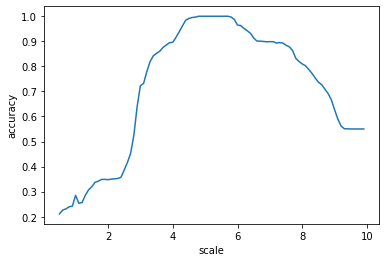

In [9]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.xlabel('scale')
plt.ylabel('accuracy')
plt.show()

In [20]:
light_model = MySimpleClassifier((224, 224, 3), 20, 4)
light_model.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 4)       112       
_________________________________________________________________
batch_normalization_12 (Batc (None, 224, 224, 4)       16        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 4)       148       
_________________________________________________________________
batch_normalization_13 (Batc (None, 224, 224, 4)       16        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 4)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 8)       296       
_________________________________________________________________
batch_normalization_14 (Batc (None, 112, 112, 8)      

In [23]:
light_model.train(d_train, val_images, val_gt_vectors)
light_model.save('saved_models/light_model_trained_on_scale_5.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/10
4000/4000 [==============================] - 16s 4ms/sample - loss: 0.0061 - accuracy: 0.9990 - val_loss: 2.4722e-04 - val_accuracy: 1.0000
Epoch 2/10
4000/4000 [==============================] - 14s 3ms/sample - loss: 0.0254 - accuracy: 0.9915 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 3/10
4000/4000 [==============================] - 14s 3ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.9009e-04 - val_accuracy: 1.0000
Epoch 4/10
4000/4000 [==============================] - 14s 3ms/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.6376e-04 - val_accuracy: 1.0000
Epoch 5/10
4000/4000 [==============================] - 14s 3ms/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/10
4000/4000 [==============================] - 15s 4ms/sample - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3474e-04 - val_accuracy: 1.0000
Epoch 7/10
4000/4000 [================

In [18]:
npz_folder = 'npz_tests'

accuraces = []
loaded_light_model = MySimpleClassifier((224, 224, 3), 20, 4)
loaded_light_model.load('saved_models/light_model_trained_on_scale_5.0')

for root, dirs, files in os.walk(Path(FOLDER) / Path(npz_folder)):
    pbar = tqdm(total=len(files))
    for filename in files:
        dtest = Dataset(npz_folder + '\\' + filename)
        pred = loaded_light_model.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        pbar.update(1)

  0%|          | 0/95 [00:00<?, ?it/s]

In [19]:
# def count_accuraces(dataset_path: Path, num: int):
#     dtest = Dataset(dataset_path)
#     pred = loaded_light_model.test_on_dataset(dtest)
#     accuraces[num] = Metrics.accuracy(dtest.labels, pred)

# def do_job(tasks_to_do):
#     while True:
#         try:
#             task = tasks_to_do.get_nowait()
#             count_accuraces(*task)
#         except queue.Empty:
#             break
#         else:
#             print(f'done with {task[0]}', flush=True)
#     return True

# def count_accuraces_parallel():
#     for root, dirs, files in os.walk(FOLDER):
#         input_params = [(Path(FOLDER + '\\' +  files[i]), i) for i in range(len(files))]

#         number_of_processes = cpu_count()
#         tasks_to_do = Queue()
#         processes = []

#         for i in input_params:
#             tasks_to_do.put(i)

#         for _ in range(number_of_processes):
#             t = threading.Thread(target=do_job, args=(tasks_to_do, ))
#             processes.append(t)
#             t.start()
        
#         for t in processes:
#             t.join()

# if __name__ == '__main__':
#     count_accuraces_parallel()

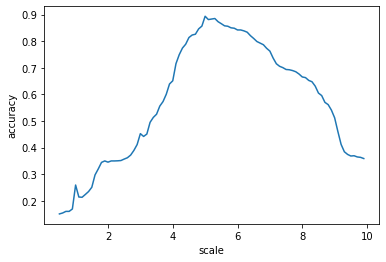

In [20]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.xlabel('scale')
plt.ylabel('accuracy')
plt.show()

In [6]:
model_noise50 = MySimpleClassifier((224, 224, 3), 20, 8)
d_train_noise50 = Dataset('npz_train_noise50/5.0.npz')
val_images, val_gt_vectors = d_train_noise50.random_batch_with_gt_vectors(int(d_train_noise50.n_files * 0.2))

In [7]:
model_noise50.train(d_train_noise50, val_images, val_gt_vectors)
model_noise50.save('saved_models/model_noise50_trained_on_scale_5.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/7
4000/4000 [==============================] - 31s 8ms/sample - loss: 1.1037 - accuracy: 0.7368 - val_loss: 1.2334 - val_accuracy: 0.6562
Epoch 2/7
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.2544 - accuracy: 0.9790 - val_loss: 0.2090 - val_accuracy: 0.9600
Epoch 3/7
4000/4000 [==============================] - 25s 6ms/sample - loss: 0.0791 - accuracy: 0.9987 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 4/7
4000/4000 [==============================] - 26s 7ms/sample - loss: 0.0389 - accuracy: 0.9998 - val_loss: 0.0326 - val_accuracy: 1.0000
Epoch 5/7
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.0254 - accuracy: 0.9995 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/7
4000/4000 [==============================] - 24s 6ms/sample - loss: 0.0165 - accuracy: 0.9998 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 7/7
4000/4000 [==============================] - 24s 6

In [8]:
loaded_model_noise50 = MySimpleClassifier((224, 224, 3), 20, 8)
loaded_model_noise50.load('saved_models/model_noise50_trained_on_scale_5.0')

In [10]:
npz_folder = 'npz_tests_noise50'

accuraces = []

for root, dirs, files in os.walk(Path(FOLDER) / Path(npz_folder)):
    pbar = tqdm(total=len(files))
    for filename in files:
        dtest = Dataset(npz_folder + '\\' + filename)
        pred = loaded_model_noise50.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        pbar.update(1)

  0%|          | 0/95 [00:00<?, ?it/s]

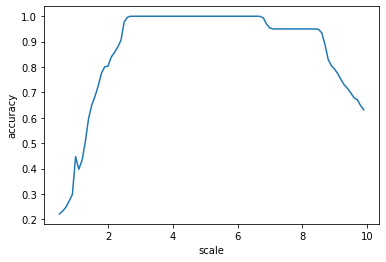

In [13]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.xlabel('scale')
plt.ylabel('accuracy')
plt.show()

In [16]:
light_model_noise50 = MySimpleClassifier((224, 224, 3), 20, 4)
light_model_noise50.train(d_train_noise50, val_images, val_gt_vectors)
light_model_noise50.save('saved_models/light_model_noise50_trained_on_scale_5.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/7
4000/4000 [==============================] - 16s 4ms/sample - loss: 1.8129 - accuracy: 0.5512 - val_loss: 8.9557 - val_accuracy: 0.0550
Epoch 2/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.8482 - accuracy: 0.8938 - val_loss: 1.6164 - val_accuracy: 0.4125
Epoch 3/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.4334 - accuracy: 0.9778 - val_loss: 0.3669 - val_accuracy: 1.0000
Epoch 4/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.2345 - accuracy: 0.9950 - val_loss: 0.2499 - val_accuracy: 0.9588
Epoch 5/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.1545 - accuracy: 0.9945 - val_loss: 0.0941 - val_accuracy: 0.9912
Epoch 6/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.1010 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 7/7
4000/4000 [==============================] - 14s 4

In [17]:
npz_folder = 'npz_tests_noise50'

accuraces = []
loaded_light_model_noise50 = MySimpleClassifier((224, 224, 3), 20, 4)
loaded_light_model_noise50.load('saved_models/light_model_noise50_trained_on_scale_5.0')

for root, dirs, files in os.walk(Path(FOLDER) / Path(npz_folder)):
    pbar = tqdm(total=len(files))
    for filename in files:
        dtest = Dataset(npz_folder + '\\' + filename)
        pred = loaded_light_model_noise50.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        pbar.update(1)

  0%|          | 0/95 [00:00<?, ?it/s]

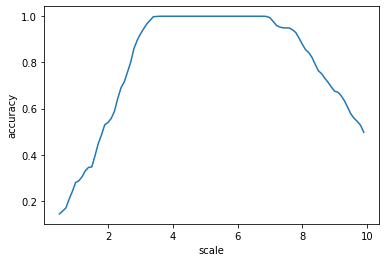

In [18]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.xlabel('scale')
plt.ylabel('accuracy')
plt.show()

In [19]:
d_train_noise100 = Dataset('npz_train_noise100/5.0.npz')
val_images, val_gt_vectors = d_train_noise100.random_batch_with_gt_vectors(int(d_train_noise100.n_files * 0.2))

In [20]:
model_noise100 = MySimpleClassifier((224, 224, 3), 20, 8)
model_noise100.train(d_train_noise100, val_images, val_gt_vectors)
model_noise100.save('saved_models/model_noise100_trained_on_scale_5.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/7
4000/4000 [==============================] - 25s 6ms/sample - loss: 1.1688 - accuracy: 0.7025 - val_loss: 2.4000 - val_accuracy: 0.2800
Epoch 2/7
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.2867 - accuracy: 0.9653 - val_loss: 0.4279 - val_accuracy: 0.8813
Epoch 3/7
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.0960 - accuracy: 0.9962 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 4/7
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.0494 - accuracy: 0.9975 - val_loss: 0.0742 - val_accuracy: 0.9837
Epoch 5/7
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.0333 - accuracy: 0.9970 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 6/7
4000/4000 [==============================] - 23s 6ms/sample - loss: 0.0191 - accuracy: 0.9998 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 7/7
4000/4000 [==============================] - 23s 6

In [21]:
npz_folder = 'npz_tests_noise100'

accuraces = []
loaded_model_noise100 = MySimpleClassifier((224, 224, 3), 20, 8)
loaded_model_noise100.load('saved_models/model_noise100_trained_on_scale_5.0')

for root, dirs, files in os.walk(Path(FOLDER) / Path(npz_folder)):
    pbar = tqdm(total=len(files))
    for filename in files:
        dtest = Dataset(npz_folder + '\\' + filename)
        pred = loaded_model_noise100.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        pbar.update(1)

  0%|          | 0/95 [00:00<?, ?it/s]

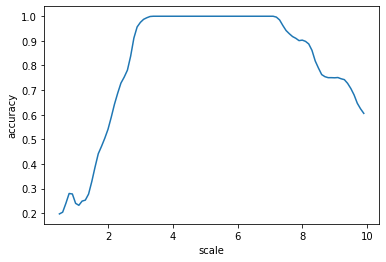

In [22]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.xlabel('scale')
plt.ylabel('accuracy')
plt.show()

In [23]:
light_model_noise100 = MySimpleClassifier((224, 224, 3), 20, 4)
light_model_noise100.train(d_train_noise100, val_images, val_gt_vectors)
light_model_noise100.save('saved_models/light_model_noise100_trained_on_scale_5.0')

training started
Train on 4000 samples, validate on 800 samples
Epoch 1/7
4000/4000 [==============================] - 17s 4ms/sample - loss: 1.8287 - accuracy: 0.5115 - val_loss: 2.8396 - val_accuracy: 0.1262
Epoch 2/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.8895 - accuracy: 0.8115 - val_loss: 1.3709 - val_accuracy: 0.4825
Epoch 3/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.5095 - accuracy: 0.9068 - val_loss: 0.4084 - val_accuracy: 0.9050
Epoch 4/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.3427 - accuracy: 0.9273 - val_loss: 0.2036 - val_accuracy: 1.0000
Epoch 5/7
4000/4000 [==============================] - 15s 4ms/sample - loss: 0.2227 - accuracy: 0.9745 - val_loss: 0.3171 - val_accuracy: 0.9375
Epoch 6/7
4000/4000 [==============================] - 14s 4ms/sample - loss: 0.1450 - accuracy: 0.9860 - val_loss: 0.1594 - val_accuracy: 0.9513
Epoch 7/7
4000/4000 [==============================] - 14s 4

In [24]:
npz_folder = 'npz_tests_noise100'

accuraces = []
loaded_light_model_noise100 = MySimpleClassifier((224, 224, 3), 20, 4)
loaded_light_model_noise100.load('saved_models/light_model_noise100_trained_on_scale_5.0')

for root, dirs, files in os.walk(Path(FOLDER) / Path(npz_folder)):
    pbar =tqdm(total=len(files))
    for filename in files:
        dtest = Dataset(npz_folder + '\\' + filename)
        pred = loaded_light_model_noise100.test_on_dataset(dtest)
        accuraces.append(Metrics.accuracy(dtest.labels, pred))
        pbar.update(1)

  0%|          | 0/95 [00:00<?, ?it/s]

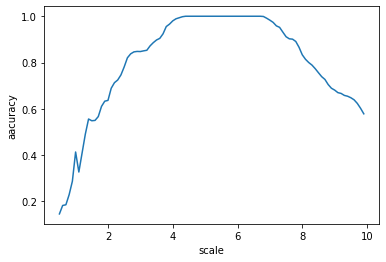

In [25]:
xpoints = np.arange(0.5, 10.0, 0.1)
ypoints = np.array(accuraces)
# print(xpoints.shape, ypoints.shape)
plt.plot(xpoints, ypoints)
plt.xlabel('scale')
plt.ylabel('aacuracy')
plt.show()